In [175]:
#загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import date
import seaborn as sns

In [176]:
pd.set_option('display.max_columns', None) # уберем ограничение по отображению количества столбцов

# 3 DonorSearch. Выбор и расчет метрик

<div style="border:solid green 2px; padding: 20px">
    
**Цель:** Выбрать и рассчитать метрики для оценки эффективности платформы.

<div style="border:solid blue 2px; padding: 20px">

**Содержание:**
    
    3.1 Загрузка и предобработка данных
        3.1.1 Датасеты донаций
            3.1.1.1 Donations - фактические донации
            3.1.1.2 Donation_plan - запланированные донации
            3.1.1.3 Note - оценки пользователей станциям забора крови
        3.1.2 Users - датасет пользователи и бонусы
    
    3.2 Расчет метрик
        3.2.1 Общие метрики о произведенных донациях
        3.2.2 Специальные метрики
            3.2.2.1 RUR - коэффициент вернувшихся пользователей
            3.2.2.2 ER - коэффициент вовлеченности
        3.2.3 Прирост активных доноров
        3.2.4 Прирост числа донаций
        3.2.5 Среднее количество донаций на 1 донора
        3.2.6 Среднее число планирования донаций на пользователя
        3.2.7 Среднее число выставляемых оценок на пользователя
        3.2.8 Скорость добавления донации на платформу
        3.2.9 Retention rate - удержание пользователей
        3.2.10 Доли доноров, сдающих кровь 1 или более раз
        3.2.11 Среднее количество дней между донациями
    
    3.3 ВЫВОД по документу

## 3.1 Загрузка и предобработка данных

### 3.1.1 Датасеты донаций

В этом пункте загрузим датасет **donations_anon 23_11** о фактических донациях пользователей (в следующей ячейке), также **donations_plan 13.11.23.csv** - данные о запланированных донациях в переменную donations_plan следующим. Затем загрузим **feedback_anon 13.11.23.csv** в переменную note - данные с оценками пользователей станциям забора крови. 

#### 3.1.1.1 Donations - фактические донации

In [177]:
#загрузим данные
url= 'https://drive.google.com/file/d/1c9uO5b2geqlelAZgsxJEsimKG2gdeMDN/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
donations = pd.read_csv(url)

donations.head(3)

,ID,ID пользователя,Класс крови,Дата донации,Дата планирования,Тип донации,Город,Регион,Страна,Место сдачи,Есть справка,Дата добавления донации,Статус донации
0,257350,61553,Плазма,23.11.2023,Не указана,Безвозмездно,Москва,Не указан,Россия,"ФГБУ НМИЦ Гематологии, (бывш. ГНЦ)",Да,23.11.2023,На модерации
1,257349,209605,Плазма,20.11.2023,Не указана,Безвозмездно,Нижний Новгород,Нижегородская область,Россия,Передвижная станция Яранского плазмоцентра ФГБ...,Да,23.11.2023,На модерации
2,257348,274248,Плазма,23.11.2023,Не указана,Безвозмездно,Елец,Липецкая область,Россия,Выездная акция,Да,23.11.2023,На модерации


In [178]:
#изучим информацию о данных
donations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248436 entries, 0 to 248435
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   ID                       248436 non-null  int64 
 1   ID пользователя          248436 non-null  int64 
 2   Класс крови              248436 non-null  object
 3   Дата донации             248436 non-null  object
 4   Дата планирования        248436 non-null  object
 5   Тип донации              248436 non-null  object
 6   Город                    248436 non-null  object
 7   Регион                   248436 non-null  object
 8   Страна                   248436 non-null  object
 9   Место сдачи              248436 non-null  object
 10  Есть справка             248436 non-null  object
 11  Дата добавления донации  248436 non-null  object
 12  Статус донации           248436 non-null  object
dtypes: int64(2), object(11)
memory usage: 24.6+ MB


In [179]:
#переименуем столбцы
donations = donations.rename(columns={'ID': 'donation_id', 'ID пользователя': 'user_id', 'Класс крови': 'blood_type',\
                                      'Дата донации': 'donation_date', 'Дата планирования': 'plan_date', 'Тип донации'\
                                      : 'donation_type', 'Город': 'city', 'Регион': 'region', 'Страна': 'country',\
                                      'Место сдачи': 'blood_center', 'Есть справка': 'med_certificate', 
                                      'Дата добавления донации': 'donation_added_date', 'Статус донации': 'donation_status'})

In [180]:
#заменим пропуски на nan
donations['plan_date'] = donations['plan_date'].replace('Не указана', np.nan)

In [181]:
#поменяем фортат данных
donations['donation_date'] = pd.to_datetime(donations['donation_date'], format='%d.%m.%Y', errors = 'coerce')
donations['plan_date'] = pd.to_datetime(donations['plan_date'], format='%d.%m.%Y', errors = 'coerce')
donations['donation_added_date'] = pd.to_datetime(donations['donation_added_date'], format='%d.%m.%Y', errors = 'coerce')

In [182]:
#добавим столбцы
donations['donation_year'] = pd.DatetimeIndex(donations['donation_date']).year
donations['donation_month'] = pd.DatetimeIndex(donations['donation_date']).month

donations['difference'] = (donations['donation_added_date'] - donations['donation_date']).dt.days
donations['donation_added_year'] = donations['donation_added_date'].dt.year

In [183]:
#поменяем фортат данных
donations[['donation_year', 'donation_month']] = donations[['donation_year', 'donation_month']].astype('Int64')

In [184]:
#изучим столбец blood_type
donations['blood_type'].value_counts()

Цельная кровь              163836
Плазма                      58763
Тромбоциты                  25287
Эритроциты                    450
Гранулоциты (Лейкоциты)       100
Name: blood_type, dtype: int64

In [185]:
#посмотрим на макс и мин даты донаций
print(donations['donation_date'].min())
print(donations['donation_date'].max())

1900-01-01 00:00:00
2092-06-10 00:00:00


Проект основан в 2013г., поэтому считаю логичным оставить для анализа данные о донациях за 2013 - 2023гг. Посмотрим, какое количество данных подлежит удалению.

In [186]:
# перед удалением запишем в новую переменную количество записей исходных
var_delete = len(donations['donation_id'])

In [187]:
print(len(donations[(donations['donation_year'] < 2013) | (donations['donation_year'] > 2023)])\
      / len(donations['donation_id']) * 100, '% данных подлежит удалению')

11.63921492859328 % данных подлежит удалению


In [188]:
#удалим ненужные данные
donations = donations[(donations['donation_year'] >= 2013) & (donations['donation_year'] <= 2023)]

In [189]:
#посмотрим на макс и мин даты планирования
print(donations['plan_date'].min())
print(donations['plan_date'].max())

2020-11-20 00:00:00
2023-11-23 00:00:00


In [190]:
#изучим столбец donation_type
donations['donation_type'].value_counts()

Безвозмездно    204204
Платно           15309
Name: donation_type, dtype: int64

In [191]:
#изучим столбец med_certificate
donations['med_certificate'].value_counts()

Да     204035
Нет     15478
Name: med_certificate, dtype: int64

In [192]:
#посмотрим на макс и мин даты добавления донаций
print(donations['donation_added_date'].min())
print(donations['donation_added_date'].max())

2020-11-18 00:00:00
2023-11-23 00:00:00


Самая ранняя дата добавляения донации - ноябрь 2020, скорее всего это связано с новой версией сайта, запущенного как раз в ноябре 2020.

In [193]:
#изучим столбец
donations['donation_status'].value_counts()

Принята         196054
Без справки      16861
Удалена           5250
Отклонена         1228
На модерации       120
Name: donation_status, dtype: int64

Донации со статусом "удалена", "отклонена", "без справки" и "на модерации "будет логично убрать из данных. Посмотрим, какой процент данных подлежит удалению.

In [194]:
print(len(donations[donations['donation_status'] != 'Принята']) / len(donations['donation_id']) *100,'% подлежит удалению')

10.686838592702937 % подлежит удалению


In [195]:
#удалим ненужные данные
donations = donations[donations['donation_status'] == 'Принята']

In [196]:
#порверим дубликаты
donations.duplicated().sum()

488

In [197]:
#удалим дубликаты
donations = donations.drop_duplicates().reset_index(drop=True)

In [198]:
# посчитаем суммарный процент потери данных в датасете donations
print((var_delete - len(donations['donation_id']))/var_delete*100,'% данных потеряли всего')

21.28113477917854 % данных потеряли всего


#### 3.1.1.2 Donation_plan - запланированные донации

Загрузим следующий датасет donation_plan о запланированных донациях:

In [199]:
#загрузим данные
donation_plan = pd.read_csv('C:/Users/User/Desktop/donor/Донации/donations_plan 13.11.23.csv')
donation_plan.head()

,ID,ID пользователя,Класс крови,Дата донации,Дата планирования,Тип донации,Регион,Место стадчи,Статус,Есть справка
0,27870,262549,Цельная кровь,14.11.2023,13.11.2023,Безвозмездно,"Россия, Ульяновская область, Димитровград",ФГБУЗ Клиническая больница №172 ФМБА России Це...,донация запланирована,Нет
1,27869,203,Цельная кровь,15.11.2023,13.11.2023,Безвозмездно,"Россия, Тульская область, Тула","ГУЗ ""Тульская областная станция переливания кр...",донация запланирована,Нет
2,27868,274735,Плазма,14.11.2023,13.11.2023,Безвозмездно,"Россия, Тульская область, Чернь",Выездная акция,планирование отменено,Нет
3,27867,260348,Цельная кровь,19.01.2024,13.11.2023,Безвозмездно,"Россия, Амурская область, Благовещенск","ГБУЗ Амурской области ""Амурская областная стан...",донация запланирована,Нет
4,27866,232312,Цельная кровь,29.11.2023,13.11.2023,Безвозмездно,"Россия, Крым, Севастополь",1472 Военно-морской клинический госпиталь имен...,донация запланирована,Нет


In [200]:
#изучим данные
donation_plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27191 entries, 0 to 27190
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 27191 non-null  int64 
 1   ID пользователя    27191 non-null  int64 
 2   Класс крови        27191 non-null  object
 3   Дата донации       27191 non-null  object
 4   Дата планирования  27191 non-null  object
 5   Тип донации        27191 non-null  object
 6   Регион             27191 non-null  object
 7   Место стадчи       27191 non-null  object
 8   Статус             27191 non-null  object
 9   Есть справка       27191 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.1+ MB


In [201]:
#переименуем столбцы
donation_plan = donation_plan.rename(columns={'ID': 'donation_id', 'ID пользователя': 'user_id', \
                                              'Класс крови': 'blood_type', 'Дата донации': 'donation_date', \
                                              'Дата планирования': 'plan_date', 'Тип донации': 'donation_type',\
                                              'Регион': 'region', 'Место стадчи': 'blood_center', \
                                              'Есть справка': 'med_certificate', 'Статус': 'status'})

In [202]:
#поменяем фортат данных
donation_plan['donation_date'] = pd.to_datetime(donation_plan['donation_date'], format='%d.%m.%Y', errors = 'coerce')
donation_plan['plan_date'] = pd.to_datetime(donation_plan['plan_date'], format='%d.%m.%Y', errors = 'coerce')

In [203]:
#добавим столбцы
donation_plan['plan_year'] = pd.DatetimeIndex(donation_plan['plan_date']).year
donation_plan['plan_month'] = pd.DatetimeIndex(donation_plan['plan_date']).month

In [204]:
#изучим столбец blood_type
donation_plan['blood_type'].value_counts()

Цельная кровь              21088
Плазма                      4126
Тромбоциты                  1837
Эритроциты                    97
Гранулоциты (Лейкоциты)       43
Name: blood_type, dtype: int64

In [205]:
#проверим даты донации
print(donation_plan['donation_date'].min())
print(donation_plan['donation_date'].max())

2020-11-20 00:00:00
2100-07-30 00:00:00


Самая ранняя дата - ноябрь 2020, что скорее всего связано с запуском новой версии сайта. Мало вероятно, что пользователи планируют донации, дальше чем на год вперед, поэтому удалим все даты позже 2024.

In [206]:
#посмотрим кол-во донаций, запланированных после 31.12.2024
len(donation_plan[donation_plan['donation_date'] > '2024-12-31'])

4

In [207]:
#удалим ненужные данные
donation_plan = donation_plan[donation_plan['donation_date'] <= '2024-12-31']

In [208]:
#проверим даты планирования
print(donation_plan['plan_date'].min())
print(donation_plan['plan_date'].max())

2020-11-19 00:00:00
2023-11-13 00:00:00


In [209]:
#изучим столбец donation_type
donation_plan['donation_type'].value_counts()

Безвозмездно    23790
Платно           3397
Name: donation_type, dtype: int64

In [210]:
#изучим столбец status
donation_plan['status'].value_counts()

донация запланирована                                 10542
запланированная донация добавлена                      8666
планирование отменено                                  7236
отказ прикрепить справку к прошедшему планированию      743
Name: status, dtype: int64

In [211]:
#изучим столбец med_certificate
donation_plan['med_certificate'].value_counts()

Нет    15592
Да     11595
Name: med_certificate, dtype: int64

#### 3.1.1.3 Note - оценки пользователей станциям забора крови

In [212]:
#загрузим данные
note = pd.read_csv('C:/Users/User/Desktop/donor/Донации/feedback_anon 13.11.23.csv')
note.head()

,ID пользователя,Место сдачи,Дата донации,Оценка
0,163363,Не указано,13.11.2023,5
1,274716,"ГУЗ ""Ульяновская областная станция переливания...",13.11.2023,5
2,274708,"ОГБУЗ ""Томский региональный центр крови""",26.10.2022,5
3,274708,Не указано,22.03.2023,5
4,155043,"ГБУЗ ""Станция переливания крови"" МЗ Краснодарс...",08.10.2021,5


In [213]:
#изучим данные
note.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16531 entries, 0 to 16530
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID пользователя  16531 non-null  int64 
 1   Место сдачи      16531 non-null  object
 2   Дата донации     16531 non-null  object
 3   Оценка           16531 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 516.7+ KB


In [214]:
#переименуем столбцы
note = note.rename(columns={'ID пользователя': 'user_id', 'Место сдачи': 'center', 'Дата донации': 'donation_date', \
                            'Оценка': 'note'})

In [215]:
#поменяем формат данных
note['donation_date'] = pd.to_datetime(note['donation_date'], format='%d.%m.%Y', errors = 'coerce')

In [216]:
#добавим столбцы
note['year'] = pd.DatetimeIndex(note['donation_date']).year
note['month'] = pd.DatetimeIndex(note['donation_date']).month

In [217]:
#проверим даты оценок
print(note['donation_date'].min())
print(note['donation_date'].max())

1988-05-03 00:00:00
2023-11-13 00:00:00


Оставим данные за период 2013-2023. Проверим, какой процент данных будет удален.

In [218]:
print(len(note[note['donation_date'] <= '2013-01-01']) / len(note['user_id']) * 100,'% данных подлежит удалению')

2.728207609944952 % данных подлежит удалению


In [219]:
#удалим ненужные данные
note = note[note['donation_date'] >= '2013-01-01']

In [220]:
#изучим столбец note
note['note'].value_counts()

5    12699
4     2317
3      931
2       94
1       38
Name: note, dtype: int64

### 3.1.2 Users - датасет пользователи и бонусы

In [221]:
#загрузим данные
users = pd.read_csv('C:/Users/User/Desktop/donor/users_anon_data_23_11.csv', low_memory=False)
users.head()

,user_id,Пол,Дата_рождения,Регион,Группа_крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,Эритроциты,Лейкоциты,Костный мозг,Почетный_донор,Отвод_от_донации,Цельная_кровь.1,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата_регистрации,Не_подтверждённые_донации,Прошедших_донаций,Донаций_до_регистрации,Последняя_активность,Теги,Указан_email,Указан_телефон,Авторизация_через_ВК,Авторизация_через_Одноклассники,Авторизация_через_Твиттер,Авторизация_через_Яндекс,Авторизация_через_Гугл,Подтверждённые_донации,Получен_значок_20,Получен_значок_100,Донаций_на_момент_регистрации,Количество_взятых_бонусов,Дата_получения_почетного_донора,Подтвержденный_почетный_донор,Предполагаемая_дата_получения_почетного_донора
0,275790,NaN,NaN,"Россия, Кемеровская область, Мыски",O(I) Rh-,NaN,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,NaN,2023-11-23,['DirectSignUp'],нет,да,нет,нет,нет,нет,нет,0,нет,нет,NaN,0,NaN,0,NaN
1,275789,Женский,NaN,NaN,NaN,NaN,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,NaN,NaN,['CardsMobile'],да,да,нет,нет,нет,нет,нет,0,нет,нет,NaN,0,NaN,0,NaN
2,275788,NaN,NaN,NaN,NaN,NaN,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,NaN,2023-11-23,['Blood'],нет,да,нет,нет,нет,нет,нет,0,нет,нет,NaN,0,NaN,0,NaN
3,275787,Мужской,1977-04-29,NaN,NaN,NaN,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,32.0,2023-11-23,['MainPage'],да,да,нет,нет,нет,да,нет,0,нет,нет,32.0,0,NaN,0,NaN
4,275786,NaN,NaN,"Россия, Москва",O(I) Rh+,NaN,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,2.0,2023-11-23,['MainPage'],да,нет,да,нет,нет,нет,нет,0,нет,нет,2.0,0,NaN,0,NaN


In [222]:
#изучим данные
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265474 entries, 0 to 265473
Data columns (total 40 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   user_id                                         265474 non-null  int64  
 1   Пол                                             103645 non-null  object 
 2   Дата_рождения                                   92547 non-null   object 
 3   Регион                                          165061 non-null  object 
 4   Группа_крови                                    51967 non-null   object 
 5   Kell-фактор                                     44538 non-null   object 
 6   Цельная кровь                                   265474 non-null  object 
 7   Плазма                                          265474 non-null  object 
 8   Тромбоциты                                      265474 non-null  object 
 9   Эритроциты                

In [223]:
#поменяем формат
users['Дата_регистрации'] = pd.to_datetime(users['Дата_регистрации'], format='%Y.%m.%d', errors = 'coerce')
users['Дата_рождения'] = pd.to_datetime(users['Дата_рождения'], format='%Y.%m.%d', errors = 'coerce')
users['Последняя_активность'] = pd.to_datetime(users['Последняя_активность'], format='%Y.%m.%d', errors = 'coerce')
users['Дата_получения_почетного_донора'] = pd.to_datetime(users['Дата_получения_почетного_донора'], format='%Y.%m.%d',\
                                                          errors = 'coerce')
users['Предполагаемая_дата_получения_почетного_донора'] = \
pd.to_datetime(users['Предполагаемая_дата_получения_почетного_донора'], format='%Y.%m.%d', errors = 'coerce')

## 3.2 Расчет метрик

### 3.2.1 Общие метрики о произведенных донациях

In [224]:
# посмотрим уникальные года добавления донации в базу
donations['donation_added_year'].unique()

array([2023, 2022, 2021, 2020], dtype=int64)

In [225]:
df = donations.copy()
for y in sorted(df['donation_added_year'].dropna().unique().tolist()):
    df_query = df[df['donation_added_year']==y]
    print('''В {} году:
    В сумме:
    1.  Общее количество пользователей: {};
    2.  Общее количество донаций: {};

    В расчете на одного человека:
    3.  Максимальное количество донаций на одного человека: {};
    4.  Минимальное количество донаций на одного человека: {};
    5.  Среднее количество донаций на одного человека: {};
    6.  Медианное количество донаций на одного человека: {};

    В расчете по времени:
    7.  Максимальный промежуток времени между датой донации и датой ее добавления в систему: {} дней;
    8.  Средний промежуток времени между датой донации и датой ее добавления в систему: {} дней;
    9. Медианный промежуток времени между датой донации и датой ее добавления в систему: {} дней.


    '''
          .format(y,
                  df_query['user_id'].nunique(),
                  df_query['donation_id'].nunique(),
                  max(df_query.groupby('user_id')['donation_id'].count()),
                  min(df_query.groupby('user_id')['donation_id'].count()),
                  round(df_query['donation_id'].nunique()/df_query['user_id'].nunique(), 2),
                  round(df_query.groupby('user_id')['donation_id'].count().median()),
                  (max(df_query['donation_added_date'] - df_query['donation_date']).days),
                  round((df_query['donation_added_date'] - df_query['donation_date']).dt.days.mean(), 2),
                  round((df_query['donation_added_date'] - df_query['donation_date']).dt.days.median())
                 ))

В 2020 году:
    В сумме:
    1.  Общее количество пользователей: 21303;
    2.  Общее количество донаций: 73128;

    В расчете на одного человека:
    3.  Максимальное количество донаций на одного человека: 145;
    4.  Минимальное количество донаций на одного человека: 1;
    5.  Среднее количество донаций на одного человека: 3.43;
    6.  Медианное количество донаций на одного человека: 1;

    В расчете по времени:
    7.  Максимальный промежуток времени между датой донации и датой ее добавления в систему: 2878 дней;
    8.  Средний промежуток времени между датой донации и датой ее добавления в систему: 1564.92 дней;
    9. Медианный промежуток времени между датой донации и датой ее добавления в систему: 1669 дней.


    
В 2021 году:
    В сумме:
    1.  Общее количество пользователей: 2573;
    2.  Общее количество донаций: 9983;

    В расчете на одного человека:
    3.  Максимальное количество донаций на одного человека: 63;
    4.  Минимальное количество донаций на одного чел

### 3.2.2 Специальные метрики

#### 3.2.2.1 RUR

RUR (Returning User Rate — коэффициент вернувшихся пользователей) — эта метрика показывает процент вернувшихся доноров из общего количества.

**Формула расчета: Returning User Rate = Количество пользователей c более 1 донацией / Количество всех пользователей * 100%**

In [226]:
df_group = donations.groupby(['user_id', 'donation_added_year'])['donation_id'].count().reset_index()

for y in sorted(df_group['donation_added_year'].unique().tolist()): # разобьем по годам
    df_group_query = df_group[df_group['donation_added_year']==y]
    
    rur = round(df_group_query[df_group_query['donation_id']>=2].shape[0] / df_group_query.shape[0] * 100, 2)
    print('Значение RUR (по дате добавления донации) в {} году состовялет {}%'.format(y, rur))

Значение RUR (по дате добавления донации) в 2020 году состовялет 46.14%
Значение RUR (по дате добавления донации) в 2021 году состовялет 60.24%
Значение RUR (по дате добавления донации) в 2022 году состовялет 53.22%
Значение RUR (по дате добавления донации) в 2023 году состовялет 54.93%


#### 3.2.2.2 ER

ER (Engagement Rate — коэффициент вовлеченности) — эта метрика показывает, сколько пользователей из общего числа доноров добавили информацию о донации в течении 90 дней после нее.

**Формула расчета: Engagement Rate = Добавления / Подписчики * 100%**

In [227]:
for y in sorted(df_group['donation_added_year'].unique().tolist()):
    df_group_query = df[df['donation_added_year']==y]
    er = round(df_group_query[(df_group_query['difference'] <= 90) & (df_group_query['difference'] >= 0)].shape[0] /
               df_group_query[df_group_query['difference'] >= 0].shape[0] * 100, 2)
    print('Значение ER в {} году состовялет {}%'.format(y, er))

Значение ER в 2020 году состовялет 1.7%
Значение ER в 2021 году состовялет 54.69%
Значение ER в 2022 году состовялет 35.42%
Значение ER в 2023 году состовялет 38.74%


### 3.2.3 Прирост активных доноров

In [228]:
#посчитаем рост количетва доноров по отношению к предыдущему году в %
donor_growth = donations.pivot_table(index='donation_year', values='user_id', aggfunc='nunique').reset_index().\
rename(columns={'user_id': 'donors_total'})

donor_growth['growth'] = round((donor_growth.shift(-1)['donors_total'] - donor_growth['donors_total']) \
                               / donor_growth['donors_total'] * 100,2) # в %
donor_growth['growth'] = donor_growth['growth'].shift(1)
donor_growth

,donation_year,donors_total,growth
0,2013,3152,NaN
1,2014,6914,119.35
2,2015,8385,21.28
3,2016,7549,-9.97
4,2017,5270,-30.19
5,2018,5444,3.30
6,2019,5343,-1.86
7,2020,4351,-18.57
8,2021,6008,38.08
9,2022,11313,88.30


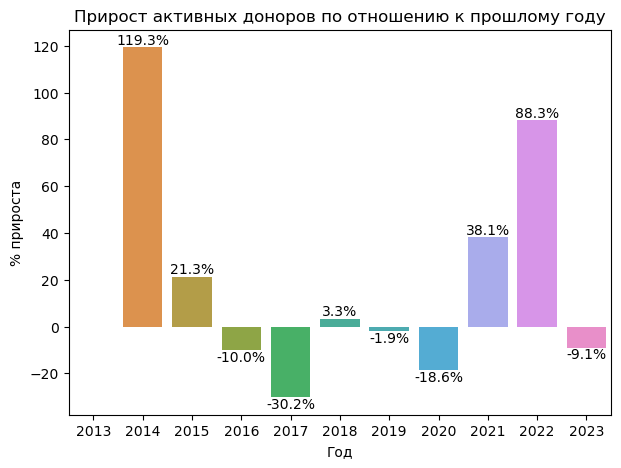

In [229]:
#построим график
plt.figure(figsize=(7,5))
ax = sns.barplot(data = donor_growth, x='donation_year', y='growth')
ax.bar_label(ax.containers[0], fmt='%.1f%%')
plt.title('Прирост активных доноров по отношению к прошлому году')
plt.xlabel('Год')
plt.ylabel('% прироста')
plt.show()

**Вывод:** 

В 2022 количество активных доноров, регистрирующих свои донации на платформе, выросло почти в 2 раза к 2021г. Рост в 2021 и 2022, возможно, связан с связан со снятием короновирусных ограничений. Также рост может быть связан с запуском новой версии сайта в ноябре 2020.

Однако, на ноябрь 2023 количество активных доноров упало на 9%. Необходимо помнить, что данные за 2023 год неполные.

In [230]:
#посмортим динамику изменения количества доноров по месяцам за последние 5 лет
growth_month = donations[donations['donation_year'] >= 2019].pivot_table(index='donation_month',\
                                                                         columns='donation_year', values='user_id',\
                                                                         aggfunc='nunique')
growth_month

donation_year,2019,2020,2021,2022,2023
donation_month,,,,,
1,1185.0,878.0,1048.0,1610.0,2312.0
2,1249.0,927.0,1171.0,1685.0,2442.0
3,1369.0,1012.0,1399.0,2364.0,2776.0
4,1519.0,1130.0,1414.0,2452.0,2398.0
5,1258.0,945.0,1188.0,1966.0,2091.0
6,1269.0,1086.0,1363.0,2265.0,2196.0
7,1263.0,1006.0,1171.0,2198.0,1909.0
8,1077.0,1023.0,1417.0,2311.0,1953.0
9,834.0,1055.0,1572.0,2410.0,1841.0


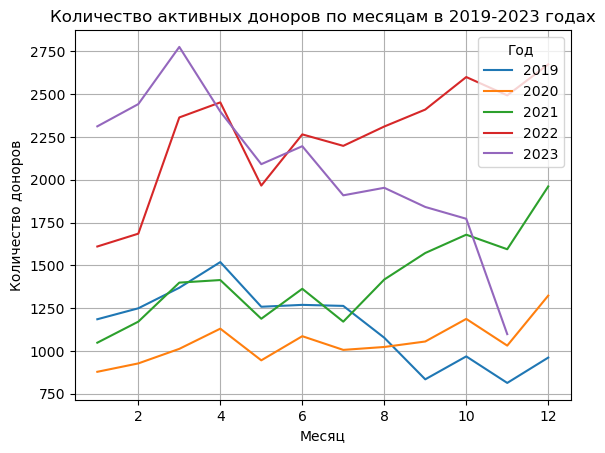

In [231]:
#построим график
sns.lineplot(data=growth_month, dashes=False)
plt.title('Количество активных доноров по месяцам в 2019-2023 годах')
plt.xlabel('Месяц')
plt.ylabel('Количество доноров')
plt.legend(title='Год')
plt.grid()
plt.show()

**Вывод:**

Динамика по всем годам похожа, прослеживается некая сезонность - пики в количестве пользователей в марте-апреле, октябре и декабре. 

В 2022 отмечается резкий рост в марте и октябре, возможно это связано с какими-то проведенными мероприятиями.

В 2023 после спада в мае показатели продолжили идти вниз с резким спадом к ноябрю. Возможно, это объясняется тем, что пользователи регистрируют свои донации с задержкой во времени, а данные за ноябрь 2023 у нас неполные.

### 3.2.4 Прирост числа донаций

In [232]:
#посчитаем прирост количества донаций по отношению к предыдущему году в %
donation_growth = donations.pivot_table(index='donation_year', values='donation_id', aggfunc='count').reset_index()\
.rename(columns={'donation_id': 'donation_total'})

donation_growth['growth'] = round((donation_growth.shift(-1)['donation_total']\
                                   - donation_growth['donation_total']) / donation_growth['donation_total'] * 100,2)

donation_growth['growth'] = donation_growth['growth'].shift(1)
donation_growth

,donation_year,donation_total,growth
0,2013,8932,NaN
1,2014,15624,74.92
2,2015,19122,22.39
3,2016,18046,-5.63
4,2017,14384,-20.29
5,2018,15627,8.64
6,2019,15019,-3.89
7,2020,14410,-4.05
8,2021,18970,31.64
9,2022,29836,57.28


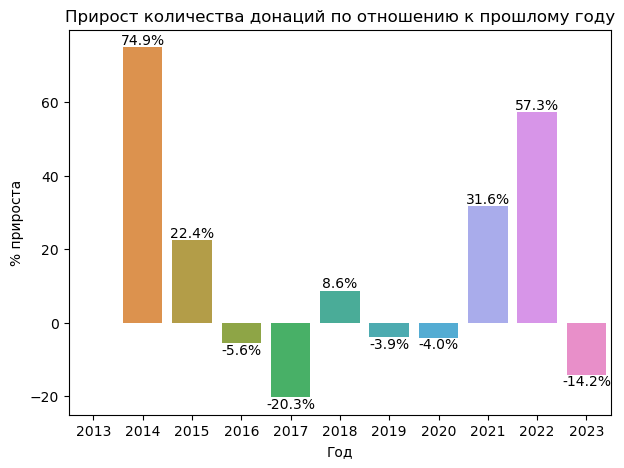

In [233]:
#построим график
plt.figure(figsize=(7,5))
ax = sns.barplot(data = donation_growth, x='donation_year', y='growth')
ax.bar_label(ax.containers[0], fmt='%.1f%%')
plt.title('Прирост количества донаций по отношению к прошлому году')
plt.xlabel('Год')
plt.ylabel('% прироста')
plt.show()

**Вывод:** Динамика прироста количества донаций повторяет динамику прироста активных доноров.

В 2022 рост составил 58%, тогда как на 23.11.2023 количество донаций упало на 14%.

In [234]:
#посмотрим динамику изменения числа донаций по месяцам за последние 5 лет
change_month = donations[donations['donation_year'] >= 2019].pivot_table(index='donation_month', \
                                                                         columns='donation_year', values='donation_id',\
                                                                         aggfunc='count')
change_month

donation_year,2019,2020,2021,2022,2023
donation_month,,,,,
1,1284.0,1075.0,1158.0,1754.0,2543.0
2,1343.0,1001.0,1253.0,1851.0,2660.0
3,1443.0,1114.0,1549.0,2601.0,3159.0
4,1739.0,1486.0,1581.0,2662.0,2710.0
5,1331.0,1055.0,1279.0,2148.0,2376.0
6,1431.0,1175.0,1555.0,2502.0,2492.0
7,1422.0,1090.0,1461.0,2414.0,2168.0
8,1210.0,1195.0,1553.0,2565.0,2226.0
9,881.0,1168.0,1765.0,2674.0,2086.0


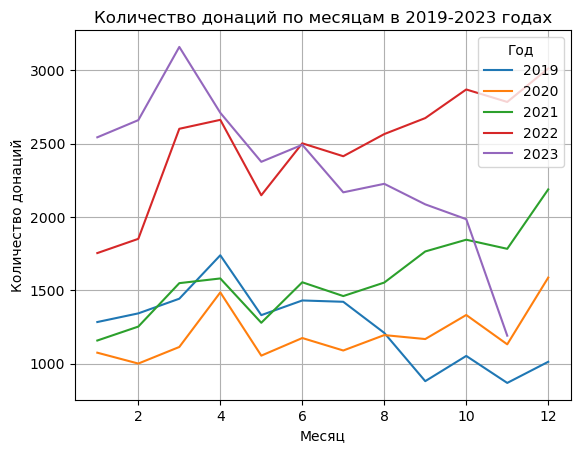

In [235]:
#построим график
sns.lineplot(data=change_month, dashes=False)
plt.title('Количество донаций по месяцам в 2019-2023 годах')
plt.xlabel('Месяц')
plt.ylabel('Количество донаций')
plt.legend(title='Год')
plt.grid()
plt.show()

**Вывод:** Динамика количества донаций похожа на динамику количества активных доноров.

В 2022 также наблюдается резкий рост числа донаций в марте и хороший рост в октябре и декабре. В 2023 мы также видим рост в марте и спад после июня.

### 3.2.5 Среднее количество донаций на 1 донора

Цельную кровь можно сдавать один раз в два месяца, не более 5 раз в год. Плазму или тромбоциты можно сдавать один раз в две недели, не более 6-12 раз в год. В связи с этой разницей рассчитаем среднее количество донаций на 1 донора для крови и для плазмы и тромбоцитов отдельно. Данных о эритроцитах и гранулоцитах (Лейкоциты) у нас очень мало.

In [236]:
#посчитаем среднее количество донаций крови на 1 донора
donations_blood = donations[donations['blood_type'] == 'Цельная кровь']
avg_blood = donations_blood.pivot_table(index='donation_year', values = ['user_id', 'donation_id'], \
                                        aggfunc={'user_id' : 'nunique', 'donation_id': 'count'})\
.rename(columns={'donation_id': 'donation_total', 'user_id': 'user_total'}).reset_index()

avg_blood['avg'] = round(avg_blood['donation_total'] / avg_blood['user_total'], 2)
avg_blood

,donation_year,donation_total,user_total,avg
0,2013,5561,2782,2.00
1,2014,10603,6070,1.75
2,2015,12882,7334,1.76
3,2016,11995,6588,1.82
4,2017,9430,4688,2.01
5,2018,10443,4900,2.13
6,2019,10139,4805,2.11
7,2020,9389,3949,2.38
8,2021,12239,5437,2.25
9,2022,20109,10191,1.97


In [237]:
#посчитаем среднее количество донаций плазмы и тромбоцитов на 1 донора
donation_plasma_tr = donations[(donations['blood_type'] == 'Тромбоциты') | (donations['blood_type'] == 'Плазма')]
avg_plasma_tr = donation_plasma_tr.pivot_table(index='donation_year', values = ['user_id', 'donation_id'], aggfunc={'user_id' : 'nunique', 'donation_id': 'count'}).rename(columns={'donation_id': 'donation_total', 'user_id': 'user_total'}).reset_index()
avg_plasma_tr['avg'] = round(avg_plasma_tr['donation_total'] / avg_plasma_tr['user_total'], 2)
avg_plasma_tr

,donation_year,donation_total,user_total,avg
0,2013,3344,698,4.79
1,2014,4996,1510,3.31
2,2015,6175,1935,3.19
3,2016,5974,1768,3.38
4,2017,4903,1252,3.92
5,2018,5130,1321,3.88
6,2019,4839,1288,3.76
7,2020,4991,1120,4.46
8,2021,6717,1593,4.22
9,2022,9689,2492,3.89


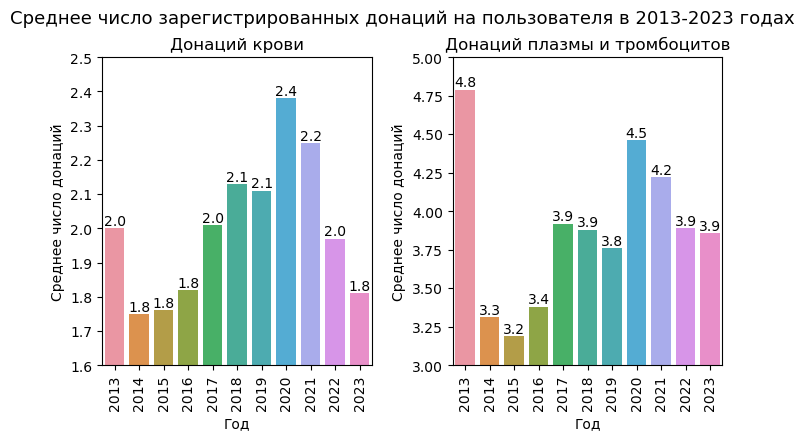

In [238]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Среднее число зарегистрированных донаций на пользователя в 2013-2023 годах', y=1, fontsize=13)

sns.barplot(data = avg_blood, x='donation_year', y='avg', ax=ax1)
ax1.bar_label(ax1.containers[0], fmt='%.1f')
ax1.set_title('Донаций крови')
ax1.set_xlabel('Год')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Среднее число донаций')
ax1.set_ylim(1.6, 2.5)

sns.barplot(data = avg_plasma_tr, x='donation_year', y='avg', ax=ax2)
ax2.bar_label(ax2.containers[0], fmt='%.1f')
ax2.set_title('Донаций плазмы и тромбоцитов')
ax2.set_xlabel('Год')
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('Среднее число донаций')
ax2.set_ylim(3, 5)

plt.subplots_adjust(wspace=0.3)

**Вывод:** Интересно, что в 2020 наблюдалось снижение количества доноров и донаций, однако, среднее число донаций на донора самое высокое в 2020. Возможно, это связано с пандемией и активным агитированием доноров к сдаче, которое привело к тому, что повторные доноры стали сдавать кровь чаще. 

Среднее число донаций крови и плазмы/тромбоцитов в 2022 и 2023 снизилось по сравнению с 2020 и 2021, что может быть связано с окончанием пандемии и снижением темпов агитирования к донорству.

### 3.2.6 Среднее число планирования донаций на пользователя

In [239]:
#данные за 2020г неполные, поэтому расчитаем метрику только для 2021-2023гг
avg_plan = donation_plan[donation_plan['plan_year'] > 2020].pivot_table(index='plan_year', \
                                                                        values=['user_id', 'donation_id'], \
                                                                        aggfunc={'user_id': 'nunique', \
                                                                                 'donation_id': 'count'})\
.reset_index().rename(columns={'donation_id': 'donation_total', 'user_id': 'users_total'})

avg_plan['avg'] = round(avg_plan['donation_total'] / avg_plan['users_total'],1)
avg_plan

,plan_year,donation_total,users_total,avg
0,2021,4009,2704,1.5
1,2022,10900,7148,1.5
2,2023,12026,7415,1.6


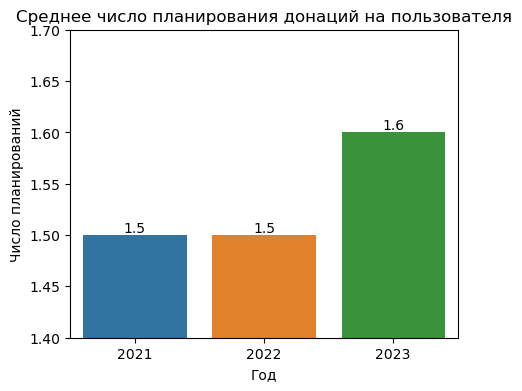

In [240]:
plt.figure(figsize=(5,4))
ax = sns.barplot(data = avg_plan, x='plan_year', y='avg')
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.title('Среднее число планирования донаций на пользователя')
plt.xlabel('Год')
plt.ylabel('Число планирований')
plt.ylim(1.4, 1.7)
plt.show()

**Вывод:** В 2022 году пользователи пользовались функцией планирования донаций также часто, как и в 2021. В 2023 значение незначительно увеличилась на **+6,7%**.

### 3.2.7 Среднее число выставляемых оценок на пользователя

In [241]:
#посчитаем среднее число выставляемых оценок на пользователя
avg_note = note.pivot_table(index = 'year', values=['user_id', 'note'], aggfunc={'user_id': 'nunique', 'note': 'count'})\
.reset_index().rename(columns={'note': 'total_notes', 'user_id': 'total_users'})

avg_note['avg'] = round(avg_note['total_notes'] / avg_note['total_users'], 1)
avg_note['year'] = avg_note['year'].astype('int')
avg_note

,year,total_notes,total_users,avg
0,2013,134,51,2.6
1,2014,191,80,2.4
2,2015,208,82,2.5
3,2016,235,85,2.8
4,2017,340,136,2.5
5,2018,391,165,2.4
6,2019,569,244,2.3
7,2020,1071,586,1.8
8,2021,3031,1642,1.8
9,2022,5320,3339,1.6


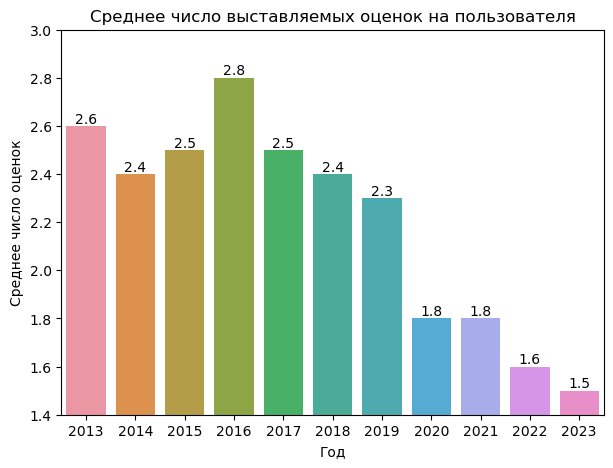

In [242]:
plt.figure(figsize=(7,5))
ax = sns.barplot(data = avg_note, x='year', y='avg')
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.title('Среднее число выставляемых оценок на пользователя')
plt.xlabel('Год')
plt.ylabel('Среднее число оценок')
plt.ylim(1.4, 3)
plt.show()

**Вывод:** В 2022 и 2023 пользователи стали менее активными в оставлении оценки после донации.

Возможно, пользователи сдают кровь всегда в одном и том же центре и со временем перестают оставлять оценки, так как качество услуг в центре не меняется. Резкое падение в 2020 году предполагаю связано со сбоем базы и потерей прежних записей в феврале месяце.

### 3.2.8 Скорость добавления донации на платформу

In [243]:
#посчитаем количество дней между датой донации и датой ее добавления на платформу
donations['speed'] = donations['donation_added_date'] - donations['donation_date']
donations['speed'] = donations['speed'].dt.days

In [244]:
#добавим столбец
donations['added_year'] = pd.DatetimeIndex(donations['donation_added_date']).year

In [245]:
#изучим данные
donations['added_year'].value_counts()

2020    73143
2023    62634
2022    49591
2021    10198
Name: added_year, dtype: int64

Функция добавления донации на платформу судя по данным была добавлена только в 2020г. Учитывая то, что пользователи могут добавлять свои прошлые донации на платформу задним числом в дату регистрации, для расчетов ограничимся только теми донациями, которые были сделаны и добавлены в одинаковом году.

In [246]:
#найдем количество дней между донацией и ее добавлением на платформу
speed = donations[(donations['donation_year'] == donations['added_year']) & (donations['donation_year'] > 2020)]\
.groupby('donation_year')['speed'].median().reset_index()

speed

,donation_year,speed
0,2021,1.0
1,2022,5.0
2,2023,1.0


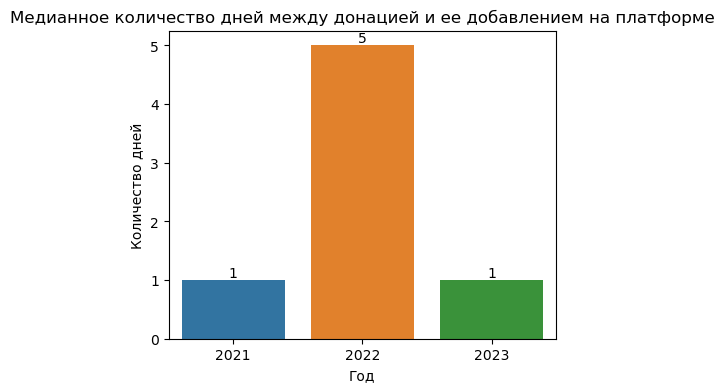

In [247]:
plt.figure(figsize=(5,4))
ax = sns.barplot(data = speed, x='donation_year', y='speed')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('Медианное количество дней между донацией и ее добавлением на платформе')
plt.xlabel('Год')
plt.ylabel('Количество дней')
plt.show()

**Вывод:** В 2022 пользователи обычно добавляли донации на платформу через 5 дней после сдачи, а в 2023 через 1 день.

### 3.2.9 Retention rate - удержание пользователей

In [248]:
#составим профили пользователей
profiles = (
        donations.sort_values(by=['user_id', 'donation_year'])
        .groupby('user_id')
        .agg({'donation_year': 'first'})
        .rename(columns={'donation_year': 'first_year'}) # год первой донации пользователя
        .reset_index()
    )
df = profiles.merge(donations, on='user_id', how='left')

#вычисляем лайфтайм
df['lifetime'] = df['donation_year'] - df['first_year']

#строим таблицу удержания
result = df.pivot_table(index='first_year', columns='lifetime', values='user_id', aggfunc='nunique')

result

lifetime,0,1,2,3,4,5,6,7,8,9,10
first_year,,,,,,,,,,,
2013,3152.0,2103.0,1585.0,1184.0,922.0,822.0,708.0,657.0,682.0,755.0,609.0
2014,4811.0,1696.0,958.0,575.0,481.0,404.0,331.0,369.0,417.0,321.0,NaN
2015,5104.0,1434.0,758.0,566.0,444.0,345.0,369.0,408.0,322.0,NaN,NaN
2016,3973.0,914.0,565.0,440.0,329.0,338.0,373.0,297.0,NaN,NaN,NaN
2017,2101.0,868.0,607.0,399.0,376.0,408.0,320.0,NaN,NaN,NaN,NaN
2018,2142.0,986.0,424.0,410.0,414.0,331.0,NaN,NaN,NaN,NaN,NaN
2019,1754.0,510.0,401.0,412.0,317.0,NaN,NaN,NaN,NaN,NaN,NaN
2020,1356.0,630.0,509.0,370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,2433.0,1313.0,739.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [249]:
#вычисляем размеры когорт
cohort_sizes = df.groupby('first_year').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})

#объединяем размеры когорт и таблицу удержания
result_grouped = cohort_sizes.merge(result, on='first_year', how='left').fillna(0)

#делим данные таблицы удержания на размеры когорт
retention = result_grouped.div(result_grouped['cohort_size'], axis=0).drop(columns=['cohort_size'])
retention

,0,1,2,3,4,5,6,7,8,9,10
first_year,,,,,,,,,,,
2013,1.0,0.667195,0.502855,0.375635,0.292513,0.260787,0.224619,0.208439,0.216371,0.239530,0.193211
2014,1.0,0.352525,0.199127,0.119518,0.099979,0.083974,0.068801,0.076699,0.086676,0.066722,0.000000
2015,1.0,0.280956,0.148511,0.110893,0.086991,0.067594,0.072296,0.079937,0.063088,0.000000,0.000000
2016,1.0,0.230053,0.142210,0.110748,0.082809,0.085074,0.093884,0.074755,0.000000,0.000000,0.000000
2017,1.0,0.413137,0.288910,0.189910,0.178962,0.194193,0.152308,0.000000,0.000000,0.000000,0.000000
2018,1.0,0.460317,0.197946,0.191410,0.193277,0.154528,0.000000,0.000000,0.000000,0.000000,0.000000
2019,1.0,0.290764,0.228620,0.234892,0.180730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020,1.0,0.464602,0.375369,0.272861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021,1.0,0.539663,0.303740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


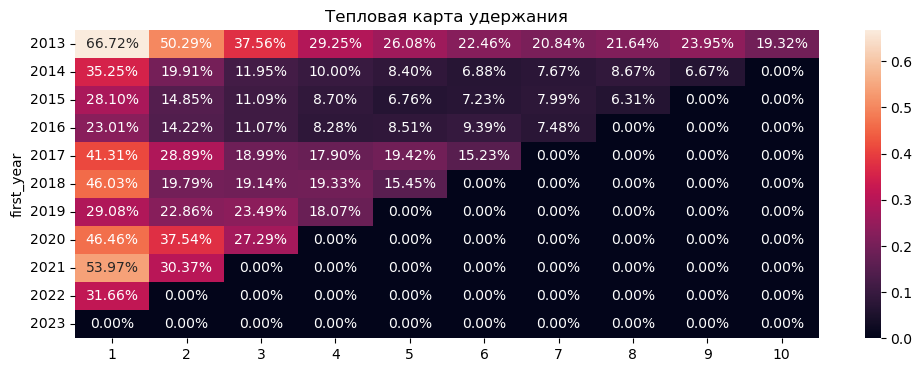

In [250]:
plt.figure(figsize=(12, 4))  # задаём размер графика
sns.heatmap(
    retention.drop(0, axis=1),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

**Вывод:** Самый высокий процент удержания пользователей в 2013г - 19% пользователей из 2013г. продолжают пользоваться платформой. Только 32% пользователей из 2022г. продолжают пользоваться платформой в 2023г., что ниже показателей 2020 и 2021г. по удержанию на 2ой год пользования продуктом. В целом видны проблемы с удержанием пользователей, в среднем 60% пользователей перестают пользоваться платформой на 2ой год после добавления первой донации.

### 3.2.10 Доли доноров, сдающих кровь 1 или более раз

Цельную кровь можно сдавать один раз в два месяца, не более 5 раз в год. Плазму или тромбоциты можно сдавать один раз в две недели, не более 6-12 раз в год. В связи с этой разницей рассчитаем среднее количество донаций на 1 донора для крови и для плазмы и тромбоцитов отдельно. Данных о эритроцитах и гранулоцитах (Лейкоциты) у нас очень мало.

In [251]:
#посчитаем количество донаций крови каждого донора с группировкой по годам
df1 = donations_blood.groupby(['donation_year', 'user_id'])['donation_id'].count().reset_index()\
.rename(columns={'donation_id': 'don_nb'})

#отфильтруем макс 5 донаций (есть пользователи, регистрирующие все свои прошлые донации в день регистрации)
df1 = df1[df1['don_nb'] <=5]

#посчитаем количество доноров с 1-5 донациями
df2 = df1.pivot_table(index='donation_year', columns='don_nb', values='user_id', aggfunc='nunique')

#найдем общее количество донаций
df2['total'] = df2.sum(axis = 1)
df2 = df2.reset_index()

df2

don_nb,donation_year,1,2,3,4,5,total
0,2013,1584,579,278,198,90,2729
1,2014,3750,1196,588,362,132,6028
2,2015,4513,1375,774,448,166,7276
3,2016,3942,1209,739,451,193,6534
4,2017,2376,984,680,406,204,4650
5,2018,2143,1210,769,529,205,4856
6,2019,2180,1111,727,498,243,4759
7,2020,1542,849,687,565,254,3897
8,2021,2269,1116,929,752,314,5380
9,2022,5292,2045,1359,976,440,10112


In [252]:
#найдем доли
df3 = round(df2.iloc[:,1:6].div(df2.total, axis=0) * 100, 1)
df3 = df3.rename(columns={1 : '1_share', 2: '2_share', 3: '3_share', 4: '4_share', 5: '5_share'})
df3

don_nb,1_share,2_share,3_share,4_share,5_share
0,58.0,21.2,10.2,7.3,3.3
1,62.2,19.8,9.8,6.0,2.2
2,62.0,18.9,10.6,6.2,2.3
3,60.3,18.5,11.3,6.9,3.0
4,51.1,21.2,14.6,8.7,4.4
5,44.1,24.9,15.8,10.9,4.2
6,45.8,23.3,15.3,10.5,5.1
7,39.6,21.8,17.6,14.5,6.5
8,42.2,20.7,17.3,14.0,5.8
9,52.3,20.2,13.4,9.7,4.4


In [253]:
#объединим таблицы
df_final = pd.concat([df2, df3], axis=1)
df_final = df_final.set_index(df_final.columns[0])
df_final

don_nb,1,2,3,4,5,total,1_share,2_share,3_share,4_share,5_share
donation_year,,,,,,,,,,,
2013,1584,579,278,198,90,2729,58.0,21.2,10.2,7.3,3.3
2014,3750,1196,588,362,132,6028,62.2,19.8,9.8,6.0,2.2
2015,4513,1375,774,448,166,7276,62.0,18.9,10.6,6.2,2.3
2016,3942,1209,739,451,193,6534,60.3,18.5,11.3,6.9,3.0
2017,2376,984,680,406,204,4650,51.1,21.2,14.6,8.7,4.4
2018,2143,1210,769,529,205,4856,44.1,24.9,15.8,10.9,4.2
2019,2180,1111,727,498,243,4759,45.8,23.3,15.3,10.5,5.1
2020,1542,849,687,565,254,3897,39.6,21.8,17.6,14.5,6.5
2021,2269,1116,929,752,314,5380,42.2,20.7,17.3,14.0,5.8


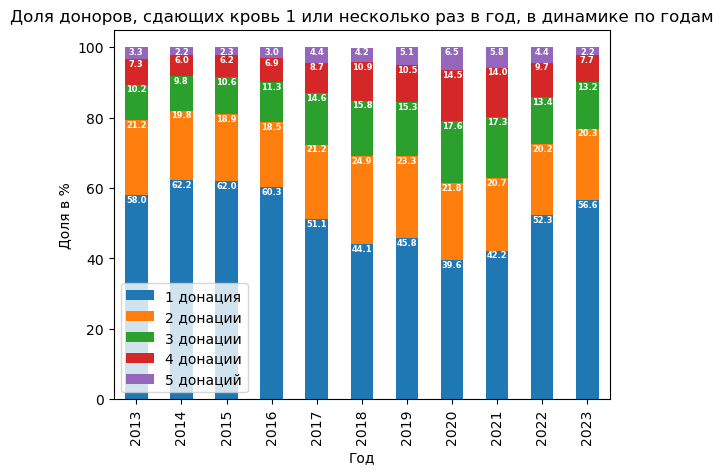

In [254]:
ax = df_final[['1_share', '2_share', '3_share', '4_share', '5_share']].plot(kind='bar', stacked=True)

y_offset = -2
for bar in ax.patches:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(bar.get_height(),1),
      ha='center',
      color='w',
      weight='bold',
      size=6
  )

plt.title('Доля доноров, сдающих кровь 1 или несколько раз в год, в динамике по годам')
plt.xlabel('Год')
plt.ylabel('Доля в %')
plt.legend(labels=['1 донация', '2 донации', '3 донации', '4 донации', '5 донаций'])
plt.show()

**Вывод:** В 2022 и 2023г. доля доноров, делающих только 1 донацию крови, увеличилась по отношению к прошлым годам. А доли доноров, делающих более 1 донации, уменьшились.

In [255]:
#посчитаем количество донаций крови каждого донора с группировкой по годам
df4 = donation_plasma_tr.groupby(['donation_year', 'user_id'])['donation_id'].count().reset_index()\
.rename(columns={'donation_id': 'don_nb'})

#отфильтруем макс 5 донаций (есть пользователи, регистрирующие все свои прошлые донации в день регистрации)
df4 = df4[df4['don_nb'] <= 8]

#посчитаем количество доноров с 1-5 донациями
df5 = df4.pivot_table(index='donation_year', columns='don_nb', values='user_id', aggfunc='nunique')

#найдем общее количество донаций
df5['total'] = df5.sum(axis = 1)
df5 = df5.reset_index()

df5

don_nb,donation_year,1,2,3,4,5,6,7,8,total
0,2013,320,83,52,41,40,26,28,8,598
1,2014,821,199,124,63,60,48,34,26,1375
2,2015,1038,288,129,106,71,75,38,36,1781
3,2016,871,274,159,104,78,51,33,25,1595
4,2017,484,221,128,87,58,48,49,43,1118
5,2018,508,223,121,101,76,60,47,45,1181
6,2019,466,232,123,99,88,66,52,38,1164
7,2020,334,195,123,101,68,60,44,37,962
8,2021,544,251,154,127,106,76,71,52,1381
9,2022,1009,370,240,158,119,118,90,67,2171


In [256]:
#найдем доли
df6 = round(df5.iloc[:,1:9].div(df5.total, axis=0) * 100, 1)
df6 = df6.rename(columns={1 : '1_share', 2: '2_share', 3: '3_share', 4: '4_share', 5: '5_share', 6: '6_share',\
                          7: '7_share', 8: '8_share'})
df6

don_nb,1_share,2_share,3_share,4_share,5_share,6_share,7_share,8_share
0,53.5,13.9,8.7,6.9,6.7,4.3,4.7,1.3
1,59.7,14.5,9.0,4.6,4.4,3.5,2.5,1.9
2,58.3,16.2,7.2,6.0,4.0,4.2,2.1,2.0
3,54.6,17.2,10.0,6.5,4.9,3.2,2.1,1.6
4,43.3,19.8,11.4,7.8,5.2,4.3,4.4,3.8
5,43.0,18.9,10.2,8.6,6.4,5.1,4.0,3.8
6,40.0,19.9,10.6,8.5,7.6,5.7,4.5,3.3
7,34.7,20.3,12.8,10.5,7.1,6.2,4.6,3.8
8,39.4,18.2,11.2,9.2,7.7,5.5,5.1,3.8
9,46.5,17.0,11.1,7.3,5.5,5.4,4.1,3.1


In [257]:
#объединим таблицы
df_final_2 = pd.concat([df5, df6], axis=1)
df_final_2 = df_final_2.set_index(df_final_2.columns[0])
df_final_2

don_nb,1,2,3,4,5,6,7,8,total,1_share,2_share,3_share,4_share,5_share,6_share,7_share,8_share
donation_year,,,,,,,,,,,,,,,,,
2013,320,83,52,41,40,26,28,8,598,53.5,13.9,8.7,6.9,6.7,4.3,4.7,1.3
2014,821,199,124,63,60,48,34,26,1375,59.7,14.5,9.0,4.6,4.4,3.5,2.5,1.9
2015,1038,288,129,106,71,75,38,36,1781,58.3,16.2,7.2,6.0,4.0,4.2,2.1,2.0
2016,871,274,159,104,78,51,33,25,1595,54.6,17.2,10.0,6.5,4.9,3.2,2.1,1.6
2017,484,221,128,87,58,48,49,43,1118,43.3,19.8,11.4,7.8,5.2,4.3,4.4,3.8
2018,508,223,121,101,76,60,47,45,1181,43.0,18.9,10.2,8.6,6.4,5.1,4.0,3.8
2019,466,232,123,99,88,66,52,38,1164,40.0,19.9,10.6,8.5,7.6,5.7,4.5,3.3
2020,334,195,123,101,68,60,44,37,962,34.7,20.3,12.8,10.5,7.1,6.2,4.6,3.8
2021,544,251,154,127,106,76,71,52,1381,39.4,18.2,11.2,9.2,7.7,5.5,5.1,3.8


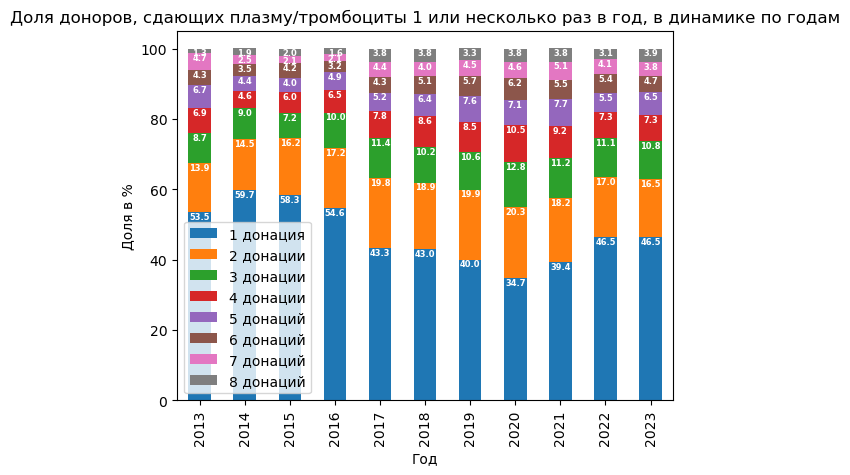

In [258]:
ax = df_final_2[['1_share', '2_share', '3_share', '4_share', '5_share', '6_share', '7_share', '8_share']]\
.plot(kind='bar', stacked=True)

y_offset = -2
for bar in ax.patches:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(bar.get_height(),1),
      ha='center',
      color='w',
      weight='bold',
      size=6
  )

plt.title('Доля доноров, сдающих плазму/тромбоциты 1 или несколько раз в год, в динамике по годам')
plt.xlabel('Год')
plt.ylabel('Доля в %')
plt.legend(labels=['1 донация', '2 донации', '3 донации', '4 донации', '5 донаций', '6 донаций', '7 донаций', '8 донаций'])
plt.show()

**Вывод:** Похожая динамика прослеживается и с донациями плазмы и тромбоцитов. В 2022 и 2023г. доля доноров, делающих только 1 донацию крови, увеличилась по отношению к прошлым годам, а доли доноров, делающих более 1 донации, уменьшились.

### 3.2.11 Среднее количество дней между донациями

In [259]:
#сделаем расчеты для доноров крови
#отфильтруем доноров по id и дате донации
don_time = donations_blood[['user_id', 'donation_year', 'donation_date']].sort_values(by=['user_id', 'donation_date'])

#добавим столбец с прошлой датой донации для каждого юзера с сортировакой по году
don_time['previous'] = don_time.groupby(['donation_year', 'user_id'])['donation_date'].shift()

#посчитаем количество дней между донациями
don_time['days_bw_donations'] = don_time['donation_date'] - don_time['previous']
don_time['days_bw_donations'] = don_time['days_bw_donations'].dt.days

#посчитаем среднее количество дней по годам
time_final = don_time.groupby('donation_year')['days_bw_donations'].mean().round().astype('int')
time_final

donation_year
2013    79
2014    89
2015    90
2016    89
2017    90
2018    92
2019    90
2020    88
2021    93
2022    90
2023    85
Name: days_bw_donations, dtype: int32

In [260]:
#сделаем расчеты для доноров плазмы и тромбоцитов
#отфильтруем доноров по id и дате донации
don_time_2 = donation_plasma_tr[['user_id', 'donation_year', 'donation_date']].sort_values(by=['user_id', 'donation_date'])

#добавим столбец с прошлой датой донации для каждого юзера с сортировакой по году
don_time_2['previous'] = don_time_2.groupby(['donation_year', 'user_id'])['donation_date'].shift()

#посчитаем количество дней между донациями
don_time_2['days_bw_donations'] = don_time_2['donation_date'] - don_time_2['previous']
don_time_2['days_bw_donations'] = don_time_2['days_bw_donations'].dt.days

#посчитаем среднее количество дней по годам
time_final_2 = don_time_2.groupby('donation_year')['days_bw_donations'].mean().round().astype('int')
time_final_2

donation_year
2013    24
2014    32
2015    34
2016    35
2017    37
2018    38
2019    39
2020    38
2021    37
2022    37
2023    33
Name: days_bw_donations, dtype: int32

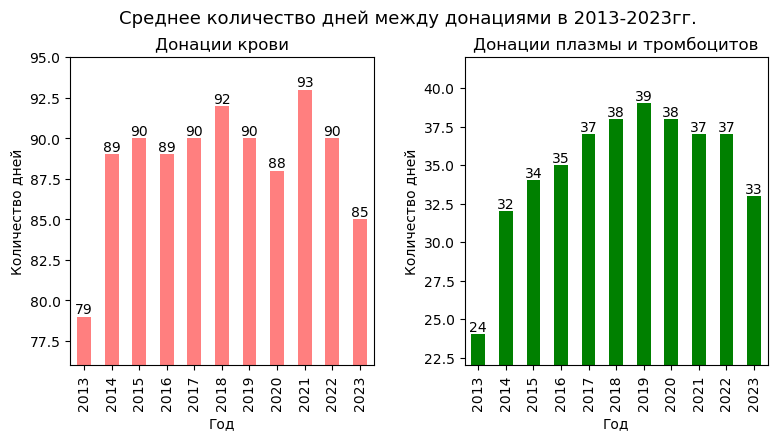

In [261]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle('Среднее количество дней между донациями в 2013-2023гг.', y=1, fontsize=13)

time_final.plot(kind='bar', ax=ax1, color='red', alpha=0.5)
ax1.bar_label(ax1.containers[0], fmt='%.f')
ax1.set_title('Донации крови')
ax1.set_xlabel('Год')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Количество дней')
ax1.set_ylim(76, 95)

time_final_2.plot(kind='bar', ax=ax2, color='green')
ax2.bar_label(ax2.containers[0], fmt='%.f')
ax2.set_title('Донации плазмы и тромбоцитов')
ax2.set_xlabel('Год')
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('Количество дней')
ax2.set_ylim(22, 42)

plt.subplots_adjust(wspace=0.3)
plt.show()

**Вывод:** Интервал между донациями крови должен составлять не менее 60 дней, а между донациями плазмы и тромбоцитов не менее 14 дней. Среднее количество донаций на пользователя в 2022 и 2023г ниже значений предыдущего года, но при этом количество дней между донациями тоже меньше значений 2021 года, что может говорить о меньшей вовлеченности в процесс сдачи крови пользователей последних двух лет.

## 3.3 ВЫВОД по документу о метриках:

<div style="border:solid red 2px; padding: 20px">

**Про прирост активных доноров и донаций:**

В 2022 количество активных доноров, регистрирующих свои донации на платформе, выросло на 88% к 2021 году. Рост в 2021 и 2022, возможно, связан с связан со снятием короновирусных ограничений. Также рост может быть связан с запуском новой версии сайта в ноябре 2020 после сбоя и потери части данных в феврале 2020.

На ноябрь 2023 количество активных доноров упало на 9% (по сравнению с 2022), но данные за 2023 год неполные – по ноябрь месяц, плюс требуется пользователям некоторое время для добавления донации на платформу.

Коэффициент вовлеченности (ER), рассчитанный по скорости добавления донации пользователем в базу, говорит, что за последние 2 года вовлеченность упала в среднем на 33% (по сравнению с 2021) -  только 39% пользователей добавляют донацию на платформу в течении 90 дней.

По месяцам динамика прироста активных доноров (и динамика прироста количества донаций) по всем годам похожа, прослеживается некая сезонность - пики в марте-апреле, октябре и декабре.

В 2022 году отмечается резкий рост в марте и октябре, возможно это связано с какими-то проведенными мероприятиями.

Динамика прироста количества донаций повторяет динамику прироста активных доноров. В 2022 рост составил 57%, тогда как на ноябрь 2023 показатель упал на 14%, напомню, данные за 2023 год неполные.

Интересно, что в 2020 наблюдалось снижение количества доноров и донаций по отношению к прошлому году, однако, среднее число донаций на донора самое высокое в 2020 году: 2,4 донации крови на 1 активного пользователя и 4,5 донации плазмы или тромбоцитов на 1 донора среди сдающих эти виды крови в этом году. Возможно, это связано с пандемией и активным агитированием доноров к сдаче, которое привело к тому, что повторные доноры стали сдавать кровь чаще. 

Среднее число донаций крови, плазмы или тромбоцитов в 2022 и 2023 годах снизилось по сравнению с 2020 и 2021 до значений 1,8 и 3,9 соответственно (2023г).

**Оценка активности на платформе:**

В 2022 году пользователи пользовались функцией планирования донаций также часто, как и в 2021. В 2023 значение незначительно увеличилась на +6,7%.

В 2022 и 2023 пользователи стали менее активными в оставлении оценки после донации. Возможно, пользователи сдают кровь всегда в одном и том же центре и со временем перестают оставлять оценки, так как качество услуг в центре не меняется.

В 2022 пользователи обычно добавляли донации на платформу через 5 дней после сдачи, а в 2023 через 1 день, как и в 2021 году.

**Про удержание:**

Самый высокий процент удержания пользователей пришедших в 2013 году - 19% пользователей из них продолжают пользоваться платформой до сих пор. Только 32% пользователей из 2022 продолжают пользоваться платформой в 2023 году, но, можно сказать: это данные по ноябрь, однако, в 2021 относительно 2020 года удержание через 1 год упало с 38% до 30%.

Также, коэффициент вернувшихся пользователей (RUR) в том же году с повторной донацией снизился в 2022 на 12% по сравнению с прошлым годом, а в 2023 году немного подрос, тем не менее значение RUR в 2023 на 19% выросло по сравнению с 2020 годом.

В 2022 и 2023 доля доноров, делающих только 1 донацию крови, увеличилась по отношению к прошлым годам. С 40% в 2020 до 57% в 2023. А доли доноров, делающих более 1 донации, соответственно, уменьшились.

Похожая динамика прослеживается и с донациями плазмы и тромбоцитов. В 2022 и 2023 доля доноров, делающих только 1 донацию крови, увеличилась по отношению к прошлым годам: с 35% в 2020 до 47% в 2023.

В целом, видны проблемы с удержанием пользователей: в среднем 60% пользователей перестают пользоваться платформой на 2-ой год после добавления первой донации.

Среднее количество донаций на пользователя в 2022 и 2023 ниже значений предыдущего года, но при этом количество дней между донациями, -  тоже меньше значений 2021 года, что может говорить о меньшей вовлеченности в процесс сдачи крови пользователей последних двух лет.
